In [1]:
import tensorflow as tf
print(tf.__version__)

import matplotlib.pyplot as plt
import baynne as bn
# from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd

from sklearn.utils import shuffle

import datetime

%matplotlib inline

# # Make reproducible
seed = 0
np.random.seed(seed)

1.10.0


Create synthetic observations:
- First describe the spatio temporal grid
- Then create a function for the synthetic observations

In [2]:
n_years = 20
lats = np.arange(-90, 90, 180/24)
lons = np.arange(-180,180, 360/24)
time = np.arange(0, n_years, 1/12)
mons = np.tile(np.arange(1, 13, 1), n_years)

In [3]:
def obs_fun(time, lat, lon, month):
    f = (0.5 * (((lat/90)  ** 2) + 0.5 * np.sin(2 * np.pi * lon/180)) - 0.2 * np.cos(np.pi * month/6))
    return f

In [4]:
obs = np.zeros([len(time), len(lats), len(lons)])
for i, t in enumerate(time):
    for j, lat in enumerate(lats):
        for k, lon in enumerate(lons):
            obs[i, j, k] = obs_fun(t, lat, lon, mons[i])

Now we can make some synthetic model output, which perform well in certain regions and have specified bias. The models also have a small amount of noise added (0.005). Where the models are correct there is Guassian noise
- Model 1: True from 30N to 90N with a 0.03 bias
- Model 2: True from 30S to 30N with no bias
- Model 3: True from 30S to 30N with no bias
- Model 4: True from 90S to 30S with +0.03 bias

We also define that the observations have the following noise:
- 0.01 for 30N to 90N 
- 0.02 for 30S to 30N 
- 0.03 for 90S to 30S 

In [5]:
idx_30s = int(len(lats) / 3)
idx_30n = - idx_30s

mdl1 = obs.copy() - 0.03 + np.random.normal(size=[len(time), len(lats), len(lons)]) * 0.005
mdl1[:,:idx_30n, :] = np.random.random([len(time), len(lats) - idx_30s, len(lons)]) * 2 - 1
mdl2 = obs.copy() + np.random.normal(size=[len(time),len(lats), len(lons)]) * 0.005 
mdl2[:,:idx_30s, :] = np.random.random([len(time), idx_30s, len(lons)]) * 2 - 1
mdl2[:,idx_30n:, :] = np.random.random([len(time), idx_30s, len(lons)]) * 2 - 1
mdl3 = obs.copy() + np.random.normal(size=[len(time), len(lats), len(lons)]) * 0.005
mdl3[:,:idx_30s, :] = np.random.random([len(time), idx_30s, len(lons)]) * 2 - 1
mdl3[:,idx_30n:, :] = np.random.random([len(time), idx_30s, len(lons)]) * 2 - 1
mdl4 = obs.copy() + 0.03 + np.random.normal(size=[len(time), len(lats), len(lons)]) * 0.005
mdl4[:,idx_30s:, :] = np.random.random([len(time), len(lats) - idx_30s, len(lons)]) * 2 - 1

# Add noise
obs[:,idx_30n:, :] = obs[:,idx_30n:, :] + np.random.normal(size=obs[:,idx_30n:, :].shape) * 0.01
obs[:,idx_30s:idx_30n, :] = obs[:,idx_30s:idx_30n, :] + np.random.normal(size=obs[:,idx_30s:idx_30n, :].shape) * 0.02
obs[:,:idx_30s, :] = obs[:,:idx_30s, :] + np.random.normal(size=obs[:,:idx_30s, :].shape) * 0.03

Plot the model 'predictions' and 'obs'

In [6]:
# Set up basemap plots
m=Basemap(lat_0=0, lon_0=0, projection='robin', resolution='c')
lon = np.arange(-180 ,181,360/len(lons))
lat = np.arange(-90 , 91, 180/len(lats))
lons_plot, lats_plot = np.meshgrid(lon, lat)
x_plot, y_plot = m(lons_plot, lats_plot)

NameError: name 'Basemap' is not defined

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(11,14))

p1 = m.pcolormesh(x_plot, y_plot, mdl1[0], vmin=-1, vmax=1, ax=axes[0][0])
axes[0][0].title.set_text('Model 1')
m.drawcoastlines(color='white', ax=axes[0][0])

p2 = m.pcolormesh(x_plot, y_plot, mdl2[0], vmin=-1, vmax=1, ax=axes[0][1])
axes[0][1].title.set_text('Model 2')
m.drawcoastlines(color='white', ax=axes[0][1])

p3 = m.pcolormesh(x_plot, y_plot, mdl3[0], vmin=-1, vmax=1, ax=axes[1][0])
axes[1][0].title.set_text('Model 3')
m.drawcoastlines(color='white', ax=axes[1][0])

p4 = m.pcolormesh(x_plot, y_plot, mdl4[0], vmin=-1, vmax=1, ax=axes[1][1])
axes[1][1].title.set_text('Model 4')
m.drawcoastlines(color='white', ax=axes[1][1])

p5 = m.pcolormesh(x_plot, y_plot, obs[0], vmin=-1, vmax=1, ax=axes[2][1])
axes[2][1].title.set_text('Obs')
m.drawcoastlines(color='white', ax=axes[2][1])

fig.delaxes(axes[2][0])

cb = fig.colorbar(p4, ax=axes.ravel().tolist(), location='bottom')
cb.set_label('Values')

We put the models, observations and defining coordinates into a dataframe.

In [7]:
df = pd.DataFrame()
df['mdl1'] = mdl1.ravel()
df['mdl2'] = mdl2.ravel()
df['mdl3'] = mdl3.ravel()
df['mdl4'] = mdl4.ravel()

To avoid the issue of longitude being discontinuous (0 degrees is the same as 360 degrees but is numerically discontinuous) we convert latitude and longitude to a cartesian coordinate system and this ensures a 1:1 mapping of coordinates.

Before we do this we have to flatten the coordinate axes. We do this because the neural net is fed one point in time and space at a time, so we need the coordinate axes to describe every one of these points. 

In [8]:
# Format data so it is suitable for NN input
data_len = obs.size
lon_data = np.tile(lons, int(data_len / len(lons))).reshape(-1,)
lat_data = np.tile(np.repeat(lats, len(lons)), len(time)).reshape(-1,)
time_data = np.repeat(time, int(data_len / len(time))).reshape(-1,)
mon_data = np.repeat(mons, int(data_len / len(time))).reshape(-1,)

x = np.cos(lat_data * np.pi / 180)  * np.cos(lon_data * np.pi / 180)
y = np.cos(lat_data * np.pi / 180)  * np.sin(lon_data * np.pi / 180)
z = np.sin(lat_data * np.pi / 180)

The same is true for the month coordinate (running 1 through 12). So we treat months in 2 dimensions much like converting the twelve hours on a clock face into cartesian coordinates.

In [9]:
rads = (mon_data / 12 * 360) * (np.pi / 180)
x_mon = np.sin(rads)
y_mon = np.cos(rads)

The way we have converted the spatial and month coordinates means that they are all between -1 and 1. A min-max scaling of -1 and 1 is important because it means that all the coordinates have equal affect to the weighting algorithm - in this case the neural network. You'll notice that the obs and model output is alerady between -1 and 1 because of the function we chose. If these values were not already scaled we would need to scale them. We therefore also need to min-max scale the temporal coordinate.

In [10]:
time_data_scaled = 2 * (time_data - time_data.min()) / (time_data.max() - time_data.min()) - 1

Though we have scaled everything between -1 and 1, these values can be tweaked to control the complexity (wiggliness) of the weighting function. For example, if we changed the latitude coordinate to be between -3 and 3, then the weighting function will fit a wigglier function with respect to latitude. Check out the paper for more details and examples. For now we'll just leave everything at 1.

In [11]:
df['x'] = x * 1
df['y'] = y * 1
df['z'] = z * 1
df['x_mon'] = x_mon * 1
df['y_mon'] = y_mon * 1
df['time'] = time_data_scaled * 1
df['obs'] = obs.ravel()

To validate the predictions we'll leave the second 10 years out from training.

The first ten years will be randomly split 85% and 15% to form the train and test sets respectively.

Note: when the train, test and validation sets are put into numpy arrays, we convert them into float32 to boost computational speed.

In [12]:
df_train_test = df[:int(10 * len(df)/20)]
df_validation = df[int(10 * len(df)/20):]

df_shuffled = df_train_test.sample(frac=1, random_state=seed)
split_idx = round(len(df_shuffled) * 0.85)
df_train = df_shuffled[:split_idx]
df_test = df_shuffled[split_idx:]

# In sample training
X_train = df_train.drop(['obs'],axis=1).values.astype(np.float32)
y_train = df_train['obs'].values.reshape(-1,1).astype(np.float32)

# The in sample testing - this is not used for training
X_test = df_test.drop(['obs'],axis=1).values.astype(np.float32)
y_test = df_test['obs'].values.reshape(-1,1).astype(np.float32)

# For out of sample validation
X_validation = df_validation.drop(['obs'],axis=1).values.astype(np.float32)
y_val = df_validation['obs'].values.reshape(-1,1).astype(np.float32)

With all of the data preprocessed it's time to set up the Bayesian neural network ensemble. We start by defining a few crucial variables and our priors.

Priors on the noise and bias

In [13]:
bias_std = 0.01

noise_mean = 0.02
noise_std = 0.004

Hyper-parameters

In [15]:
tf.reset_default_graph()

num_models = 4                      # Number of (geo)physical models 
n_ensembles = 20                    # Number of neural nets in ensemble
hidden_size = 50                    # Number of nodes in hidden layers
n_epochs = 100                      # Number of epochs to train for
batch_size = 1000
learning_rate = 0.001

n_data = X_train.shape[0]                # number of obs
x_dim = X_train.shape[1]
alpha_dim = x_dim - num_models      # Number of coordinates
y_dim = 1

Our prior is that all models should be weighted equally i.e. a multi model mean should be the output of the untrained BayNNE. To encode this prior into the BayNNE we determine standard deviations for the networks' weights and bias. This is trial and error to some extent (see below).

In [16]:
init_stddev_1_w =  np.sqrt(3.0/(alpha_dim))
init_stddev_1_b = init_stddev_1_w
init_stddev_2_w =  (1.5)/np.sqrt(hidden_size)
init_stddev_2_b = init_stddev_2_w
init_stddev_3_w = (1.5*bias_std)/np.sqrt(hidden_size)
init_stddev_noise_w = (1.0)/np.sqrt(hidden_size)

lambda_anchor = 1.0/(np.array([init_stddev_1_w,init_stddev_1_b,init_stddev_2_w,init_stddev_2_b,init_stddev_3_w,init_stddev_noise_w])**2)

With that all set up we can initialise out the neural networks within the ensemble, where the network weights and biases are drawn from distributions defined by the standard deviations above.

In [19]:
NNs=[]

sess = tf.Session()
init_weights = []

for ens in range(0,n_ensembles):
    # These steps initialise the neural networks
    NNs.append(bn.NN(x_dim, y_dim, alpha_dim, num_models, n_data, hidden_size, 
                     init_stddev_1_w, init_stddev_1_b, init_stddev_2_w, init_stddev_2_b, init_stddev_3_w, init_stddev_noise_w,
                     learning_rate))
    global_vars = tf.global_variables()
    is_not_initialized = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
    NNs[ens].anchor(sess, lambda_anchor)

Now for the crucial check: ensuring that the untrained network matches our priors

The most important check is that the presoftmax layer has a standard deviation of 1 - this ensures that the untrained network is equally likely to predict any combination of model weights. See figure 2b in the paper for more info

In [22]:
alpha_w = np.array(bn.get_layer2_output(NNs, X_train, sess))
print('Layer 2 mean: {}'.format(np.mean(alpha_w.ravel())))
print('Layer 2 Std: {}'.format(np.mean(np.std(alpha_w, axis=0).ravel())))

Layer 2 mean: 0.024789433926343918
Layer 2 Std: 1.0769997835159302


It also a good idea to check that the model weights (alphas) and model bias (beta) are the values we encoded in the network

In [23]:
alphas = np.array(bn.get_alphas(NNs, X_train, sess))
print('Alpha mean should be: {}'.format(1/num_models))
print('Alpha mean is: {}'.format(np.mean(np.array(alphas).ravel())))
print('Alpha std should be: {}'.format(np.sqrt((1/(1 + num_models)) * (1/num_models)*(1-(1/num_models)))))
print('Alpha std is: {}'.format(np.mean(np.std(np.array(alphas), axis=0).ravel())))
print('')

### Beta
beta = np.array(bn.get_betas(NNs, X_train, sess))
print('Beta mean should be: {}'.format(0))
print('Beta mean is: {}'.format(np.mean(beta.ravel())))
print('Beta std should be: {}'.format(bias_std))
print('Beta std is: {}'.format(np.std(beta.ravel())))

Alpha mean should be: 0.25
Alpha mean is: 0.25
Alpha std should be: 0.19364916731037085
Alpha std is: 0.20167286694049835

Beta mean should be: 0
Beta mean is: -0.0014567244797945023
Beta std should be: 0.01
Beta std is: 0.010225356556475163


Now we can train. We train each neural network in the ensemble sequentially, shuffling the training data every 50 epochs. In training we record the RMSE, the anchored loss (which is what we are minismising) and the anchoring term, which is a measure of how far away we are from our prior network weights and biases.

In [25]:
l_s = []
m_s = []
a_s = []

for ens in range(0,n_ensembles):
    ep_ = 0
    losses = []
    mses = []
    anchs = []
    print('NN:',ens + 1)
    while ep_ < n_epochs:
        if (ep_ % 50 == 0):
            X_train, y_train = shuffle(X_train, y_train, random_state = ep_)

        ep_ += 1
        for j in range(int(n_data/batch_size)): #minibatch training loop
            feed_b = {}
            feed_b[NNs[ens].inputs] = X_train[j*batch_size:(j+1)*batch_size, :]
            feed_b[NNs[ens].y_target] = y_train[j*batch_size:(j+1)*batch_size, :]
            blank = sess.run(NNs[ens].optimizer, feed_dict=feed_b)
        if (ep_ % 50) == 0: 
            feed_b = {}
            feed_b[NNs[ens].inputs] = X_train
            feed_b[NNs[ens].y_target] = y_train
            loss_mse = sess.run(NNs[ens].mse_, feed_dict=feed_b)
            loss_anch = sess.run(NNs[ens].loss_, feed_dict=feed_b)
            loss_anch_term = sess.run(NNs[ens].loss_anchor, feed_dict=feed_b)
            losses.append(loss_anch)
            mses.append(loss_mse)
            anchs.append(loss_anch_term)
        if (ep_ % 50 == 0):
            print('epoch:' + str(ep_) + ' at ' + str(datetime.datetime.now()))
            print(', rmse_', np.round(np.sqrt(loss_mse),5), ', loss_anch', np.round(loss_anch,5), ', anch_term', np.round(loss_anch_term,5))
    l_s.append(losses)
    m_s.append(mses)
    a_s.append(anchs)

NN: 1
epoch:50 at 2020-09-29 17:49:24.895697
, rmse_ 0.05122 , loss_anch -4.81539 , anch_term 0.01466
epoch:100 at 2020-09-29 17:49:29.704519
, rmse_ 0.02331 , loss_anch -6.74755 , anch_term 0.04762
NN: 2
epoch:50 at 2020-09-29 17:49:35.193180
, rmse_ 0.05154 , loss_anch -5.21796 , anch_term 0.01613
epoch:100 at 2020-09-29 17:49:38.855370
, rmse_ 0.02323 , loss_anch -6.74393 , anch_term 0.04744
NN: 3
epoch:50 at 2020-09-29 17:49:43.766682
, rmse_ 0.06624 , loss_anch -4.61154 , anch_term 0.01398
epoch:100 at 2020-09-29 17:49:47.197460
, rmse_ 0.02439 , loss_anch -6.65358 , anch_term 0.04219
NN: 4
epoch:50 at 2020-09-29 17:49:51.499485
, rmse_ 0.05425 , loss_anch -5.17675 , anch_term 0.01478
epoch:100 at 2020-09-29 17:49:55.000252
, rmse_ 0.02362 , loss_anch -6.7114 , anch_term 0.04278
NN: 5
epoch:50 at 2020-09-29 17:49:59.464712
, rmse_ 0.08225 , loss_anch -3.99321 , anch_term 0.01704
epoch:100 at 2020-09-29 17:50:02.996621
, rmse_ 0.03464 , loss_anch -5.94506 , anch_term 0.02768
NN: 6


Make predictions for train, test and validations

In [26]:
#use trained NN ensemble to generate predictions
y_preds_train, y_preds_mu_train, y_preds_std_train, y_preds_std_train_epi, y_preds_noisesq_train = bn.fn_predict_ensemble(NNs,X_train, sess)
y_preds_test, y_preds_mu_test, y_preds_std_test, y_preds_std_test_epi, y_preds_noisesq_test = bn.fn_predict_ensemble(NNs,X_test, sess)
y_preds_val, y_preds_mu_val, y_preds_std_val, y_preds_std_val_epi, y_preds_noisesq_val = bn.fn_predict_ensemble(NNs,X_validation, sess)

A little function for putting the flattened data back into 3 dimensions, and another for assessing how good the uncertainty quantification is (i.e. is it inline with Gaussian errors)

In [27]:
def reshape3d(in_array):

    lat_len = len(lats)
    lon_len = len(lons)
    time_len = len(time)

    output = np.zeros([time_len, lat_len, lon_len])

    for t in range(time_len):
        output[t,:,:] = in_array[lat_len * lon_len * (t): lat_len * lon_len * (t+1)].reshape([lat_len, lon_len])
    
    return output


def report_on_percentiles(y, y_pred, y_std):

    n = len(y.ravel())
    n1 = np.sum(np.abs(y_pred.ravel() - y.ravel()) <= y_std.ravel() * 1)
    n2 = np.sum(np.abs(y_pred.ravel() - y.ravel()) <= y_std.ravel() * 2)
    n3 = np.sum(np.abs(y_pred.ravel() - y.ravel()) <= y_std.ravel() * 3)
    print('{} within 1 std'.format(100 * n1 / n))
    print('{} within 2 std'.format(100 * n2 / n))
    print('{} within 3 std'.format(100 * n3 / n))

    return

Firstly let's look at the performance of the BayNNE - root mean squard and negative log likelihood for train, test and validation.

In [28]:
print('Train NLL: {}'.format(np.mean(0.5*((((y_preds_mu_train.ravel() - y_train.ravel())**2)/((y_preds_std_train.ravel()**2)) + np.log(y_preds_std_train.ravel()**2) + np.log(2*np.pi))))))
print('Test NLL: {}'.format(np.mean(0.5*((((y_preds_mu_test.ravel() - y_test.ravel())**2)/((y_preds_std_test.ravel()**2)) + np.log(y_preds_std_test.ravel()**2) + np.log(2*np.pi))))))
print('Out of sample NLL: {}'.format(np.mean(0.5*((((y_preds_mu_val.ravel() - y_val.ravel())**2)/((y_preds_std_val.ravel()**2)) + np.log(y_preds_std_val.ravel()**2) + np.log(2*np.pi))))))

Train NLL: -2.456717014312744
Test NLL: -2.466005563735962
Out of sample NLL: -2.3556315898895264


In [29]:
print('Train RMSE: {}'.format(np.sqrt(np.mean(np.square(y_preds_mu_train.ravel() - y_train.ravel())))))
print('Test RMSE: {}'.format(np.sqrt(np.mean(np.square(y_preds_mu_test.ravel() - y_test.ravel())))))
print('Out of sample RMSE: {}'.format(np.sqrt(np.mean(np.square(y_preds_mu_val.ravel() - y_val.ravel())))))

Train RMSE: 0.023772409185767174
Test RMSE: 0.023385705426335335
Out of sample RMSE: 0.02620028890669346


We can look if the uncertainty quantification is good. We would expect 68%, 95%, 98% of the points to lie within 1, 2, 3 standard deviations respectively.

In [30]:
print('For training')
report_on_percentiles(y_train, y_preds_mu_train, y_preds_std_train)
print('For testing')
report_on_percentiles(y_test, y_preds_mu_test, y_preds_std_test)
print('For out of sample')
report_on_percentiles(y_val, y_preds_mu_val, y_preds_std_val)

For training
73.47834967320262 within 1 std
97.25456154684096 within 2 std
99.88596132897604 within 3 std
For testing
73.94868827160494 within 1 std
97.41512345679013 within 2 std
99.93248456790124 within 3 std
For out of sample
81.67824074074075 within 1 std
99.0379050925926 within 2 std
99.96527777777777 within 3 std


Has the BayNNE managed to recover the model weights, biases and aleatoric (observational) noise we designed? We do in sample (in) and out of sample (validation) seperately - largely because of RAM constraints

In [31]:
X_in = df_train_test.drop(['obs'],axis=1).values.astype(np.float32)
y_in = df_train_test['obs'].values.reshape(-1,1).astype(np.float32)

alphas = np.array(bn.get_alphas(NNs, X_in, sess))
alpha_in = np.mean(alphas, axis=0)

betas = np.array(bn.get_betas(NNs, X_in, sess))
beta_in = np.mean(betas, axis=(0,2))

aleatoric_noises = bn.get_aleatoric_noise(NNs, X_in, sess)
a_n_in = np.mean(np.array(aleatoric_noises), axis=0)

alphas = np.array(bn.get_alphas(NNs, X_validation, sess))
alpha_out = np.mean(alphas, axis=0)

betas = np.array(bn.get_betas(NNs, X_validation, sess))
beta_out = np.mean(betas, axis=(0,2))

aleatoric_noises = bn.get_aleatoric_noise(NNs, X_in, sess)
a_n_out = np.mean(np.array(aleatoric_noises), axis=0)

In [33]:
noise = reshape3d(np.hstack([a_n_in, a_n_out]))
alpha = np.vstack([alpha_in, alpha_out])
beta = np.hstack([beta_in, beta_out])

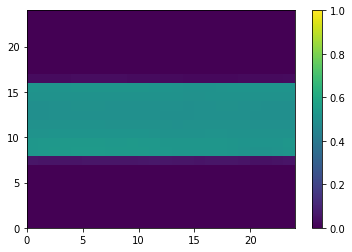

In [40]:
plt.pcolormesh(reshape3d(alpha[:, 2])[180], vmin=0, vmax=1)
plt.colorbar()

NameError: name 'm' is not defined

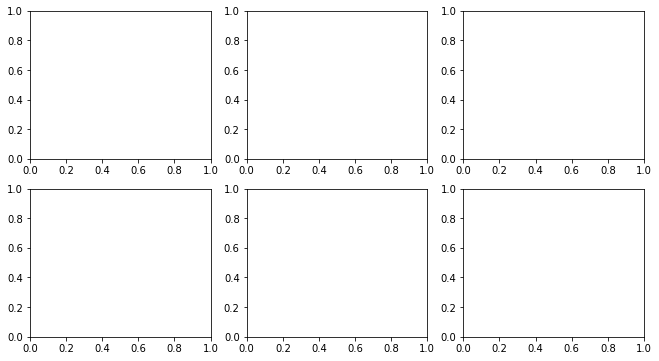

In [34]:
# Plot model coefficients
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(11,6))

p1 = m.pcolormesh(x_plot, y_plot, reshape3d(alpha[:, 0])[180], vmin=0, vmax=1, ax=axes[0][0])
axes[0][0].xaxis.set_ticklabels([])
axes[0][0].title.set_text('Model 1')
m.drawcoastlines(color='white', ax=axes[0][0])

p2 = m.pcolormesh(x_plot, y_plot, reshape3d(alpha[:, 1])[180], vmin=0, vmax=1, ax=axes[0][1])
axes[0][1].xaxis.set_ticklabels([])
axes[0][1].yaxis.set_ticklabels([])
axes[0][1].title.set_text('Model 2')
m.drawcoastlines(color='white', ax=axes[0][1])

p3 = m.pcolormesh(x_plot, y_plot, reshape3d(alpha[:, 2])[180], vmin=0, vmax=1, ax=axes[1][0])
axes[1][0].title.set_text('Model 3')
m.drawcoastlines(color='white', ax=axes[1][0])

p4  = m.pcolormesh(x_plot, y_plot, reshape3d(alpha[:, 3])[180], vmin=0, vmax=1, ax=axes[1][1])
axes[1][1].yaxis.set_ticklabels([])
axes[1][1].title.set_text('Model 4')
m.drawcoastlines(color='white', ax=axes[1][1])

p5 = m.pcolormesh(x_plot, y_plot, reshape3d(beta)[180], vmin=-0.03, vmax=0.03, ax=axes[0][2], cmap=plt.cm.inferno)
axes[0][2].yaxis.set_ticklabels([])
axes[0][2].title.set_text('Model bias')
m.drawcoastlines(color='white', ax=axes[0][2], )
cbar = m.colorbar(p5, ax=axes[0][2])
cbar.set_ticks([-0.03,0,0.03])

p6 = m.pcolormesh(x_plot, y_plot, noise[180], ax=axes[1][2], vmin=0.01, cmap=plt.cm.inferno)
axes[1][2].yaxis.set_ticklabels([])
axes[1][2].title.set_text('Aleatoric noise')
m.drawcoastlines(color='white', ax=axes[1][2])
m.colorbar(p6, ax=axes[1][2])

cb = fig.colorbar(p4, ax=axes[:2, :2].ravel().tolist(), location='bottom')
cb.set_label('Model weights')